<a href="https://colab.research.google.com/github/dralgroup/MLinQCbook22-NN/blob/main/NN_train_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install torch matplotlib numpy
! wget https://raw.githubusercontent.com/dralgroup/MLinQCbook22-NN/main/R_451.dat
! wget https://raw.githubusercontent.com/dralgroup/MLinQCbook22-NN/main/E_FCI_451.dat

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from copy import deepcopy

In [ ]:
X_all = np.loadtxt('R_451.dat', dtype=np.float32)
Y_all = np.loadtxt('E_FCI_451.dat', dtype=np.float32)
train_num = 20
val_ratio = 0.2
val_num = int(train_num * val_ratio)

train_idx = np.linspace(0, len(X_all)-1, train_num, dtype=np.int32)
X_train = X_all[train_idx].reshape(-1, 1)
Y_train = Y_all[train_idx].reshape(-1, 1)
test_idx = np.setdiff1d(np.arange(len(X_all)), train_idx)
X_test = X_all[test_idx].reshape(-1, 1)
Y_test = Y_all[test_idx].reshape(-1, 1)

np.random.seed(1)
val_idx = np.random.choice(np.arange(train_num), val_num, replace=False)
train_idx = np.setdiff1d(np.arange(train_num), val_idx)

x_train = torch.from_numpy(X_train[train_idx])
x_val = torch.from_numpy(X_train[val_idx])
y_train = torch.from_numpy(Y_train[train_idx])
y_val = torch.from_numpy(Y_train[val_idx])
x_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(Y_test)

train_ds = data.TensorDataset(x_train, y_train)

In [ ]:
class RBF(nn.Module):
    def __init__(self, in_feature: int):
        super().__init__()
        self.c = nn.Parameter(torch.Tensor(in_feature))
        self.a = nn.Parameter(torch.Tensor(1))
        nn.init.normal_(self.c, 3, 1)
        nn.init.normal_(self.a, 1, 0.5)
    
    def forward(self, input):
        c = self.c.unsqueeze(0).expand(input.size(0), -1)
        return torch.exp(-self.a * (input - c).pow(2))

class NN_RBF(nn.Module):
    def __init__(self, *features):
        super().__init__()
        i = 0; layers = []
        while i < len(features)-1:
            layers.append(nn.Linear(features[i], features[i+1]))
            layers.append(RBF(features[i+1]))
            i += 1
        layers.pop()
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)
    
class NN_Linear(nn.Module):
    def __init__(self, *features):
        super().__init__()
        i = 0; layers = []
        while i < len(features)-1:
            layers.append(nn.Linear(features[i], features[i+1]))
            i += 1
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
def train(model, dataset, x_val, y_val, batch_size, epoch_num=10000):
    loss_fn = nn.MSELoss()
    model.train()
    optimizer = optim.Adam(params=model.parameters())
    optimizer.zero_grad()
    best_loss = 1; best_model = None
    train_loss_list = []; val_loss_list = []
    for epoch_idx in range(1, epoch_num + 1):
        train_loss = []
        for (batch_x, batch_y) in  data.DataLoader(dataset, batch_size=batch_size, shuffle=True) :
            pred = model(batch_x)
            loss = loss_fn(pred, batch_y)
            model.zero_grad()
            loss.backward()
            train_loss.append(loss.detach())
            optimizer.step()
        train_loss_list.append(np.array(train_loss).mean())
        model.eval()
        with torch.no_grad():
            pred = model(x_val)
            loss = loss_fn(pred, y_val).detach()
            val_loss_list.append(loss)
            if best_loss > loss:
                best_loss = loss
                best_model = deepcopy(model)
        model.train()
        if epoch_idx % 1000 == 0:
            print(f'epoch: {epoch_idx} train loss: {np.array(train_loss).mean():.4e} \t validate loss: {loss:.4e}')
    train_loss_arr, val_loss_arr = np.array(train_loss_list), np.array(val_loss_list)
    print(f'best validation loss model: \t validation loss: {best_loss:.4e}')
    return best_model, train_loss_arr, val_loss_arr 

In [ ]:
torch.manual_seed(1)
linear_model = NN_Linear(1, 64, 1)
linear_model, train_loss_linear, val_loss_linear = train(linear_model, train_ds, 
                                           x_val, y_val, batch_size=len(train_idx))

epoch: 1000 train loss: 1.0883e-03 	 validate loss: 8.0106e-04
epoch: 2000 train loss: 1.0883e-03 	 validate loss: 8.0106e-04
epoch: 3000 train loss: 1.0883e-03 	 validate loss: 8.0106e-04
epoch: 4000 train loss: 1.0883e-03 	 validate loss: 8.0106e-04
epoch: 5000 train loss: 1.0883e-03 	 validate loss: 8.0106e-04
epoch: 6000 train loss: 1.0883e-03 	 validate loss: 8.0106e-04
epoch: 7000 train loss: 1.0883e-03 	 validate loss: 8.0106e-04
epoch: 8000 train loss: 1.0883e-03 	 validate loss: 8.0106e-04
epoch: 9000 train loss: 1.0883e-03 	 validate loss: 8.0105e-04
epoch: 10000 train loss: 1.0883e-03 	 validate loss: 8.0106e-04
best validation loss model: 	 validation loss: 7.4465e-04


In [ ]:
torch.manual_seed(1)
rbf_model = NN_RBF(1, 64, 1)
rbf_model, train_loss_rbf, val_loss_rbf = train(rbf_model, train_ds, 
                                     x_val, y_val, batch_size=len(train_idx))

epoch: 1000 train loss: 3.7938e-04 	 validate loss: 9.9444e-05
epoch: 2000 train loss: 1.8161e-04 	 validate loss: 1.8556e-05
epoch: 3000 train loss: 1.0781e-04 	 validate loss: 7.3743e-05
epoch: 4000 train loss: 2.0123e-05 	 validate loss: 8.2089e-05
epoch: 5000 train loss: 4.9923e-06 	 validate loss: 2.2060e-05
epoch: 6000 train loss: 1.3330e-06 	 validate loss: 8.4731e-06
epoch: 7000 train loss: 7.8504e-07 	 validate loss: 4.8663e-06
epoch: 8000 train loss: 6.0178e-07 	 validate loss: 3.4626e-06
epoch: 9000 train loss: 4.6506e-07 	 validate loss: 2.4873e-06
epoch: 10000 train loss: 3.2782e-07 	 validate loss: 1.7722e-06
best validation loss model: 	 validation loss: 1.7702e-06


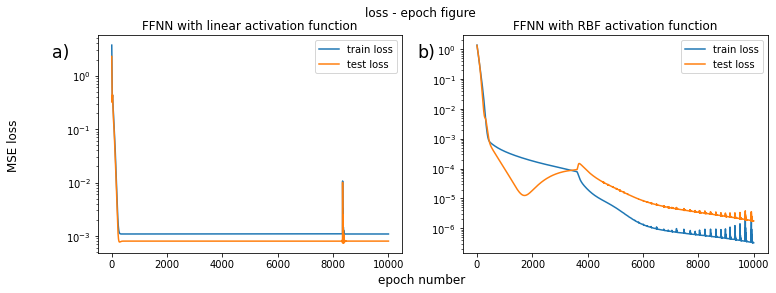

In [ ]:
plt.figure(figsize=(12, 4))
plt.suptitle('loss - epoch figure ')
plt.gcf().supxlabel('epoch number')
plt.gcf().supylabel('MSE loss')

plt.subplot(121)
plt.plot(train_loss_linear, label='train loss')
plt.plot(val_loss_linear, label='validation loss')
plt.gca().set_yscale('log')
plt.title('FFNN with linear activation function')
plt.text(x=-0.15, y=0.9, s='a)', fontsize='xx-large', transform=plt.gca().transAxes)
plt.legend()

plt.subplot(122)
plt.plot(train_loss_rbf, label='train loss')
plt.plot(val_loss_rbf, label='validation loss')
plt.gca().set_yscale('log')
plt.title('FFNN with RBF activation function')
plt.text(x=-0.15, y=0.9, s='b)', fontsize='xx-large', transform=plt.gca().transAxes)
plt.legend()

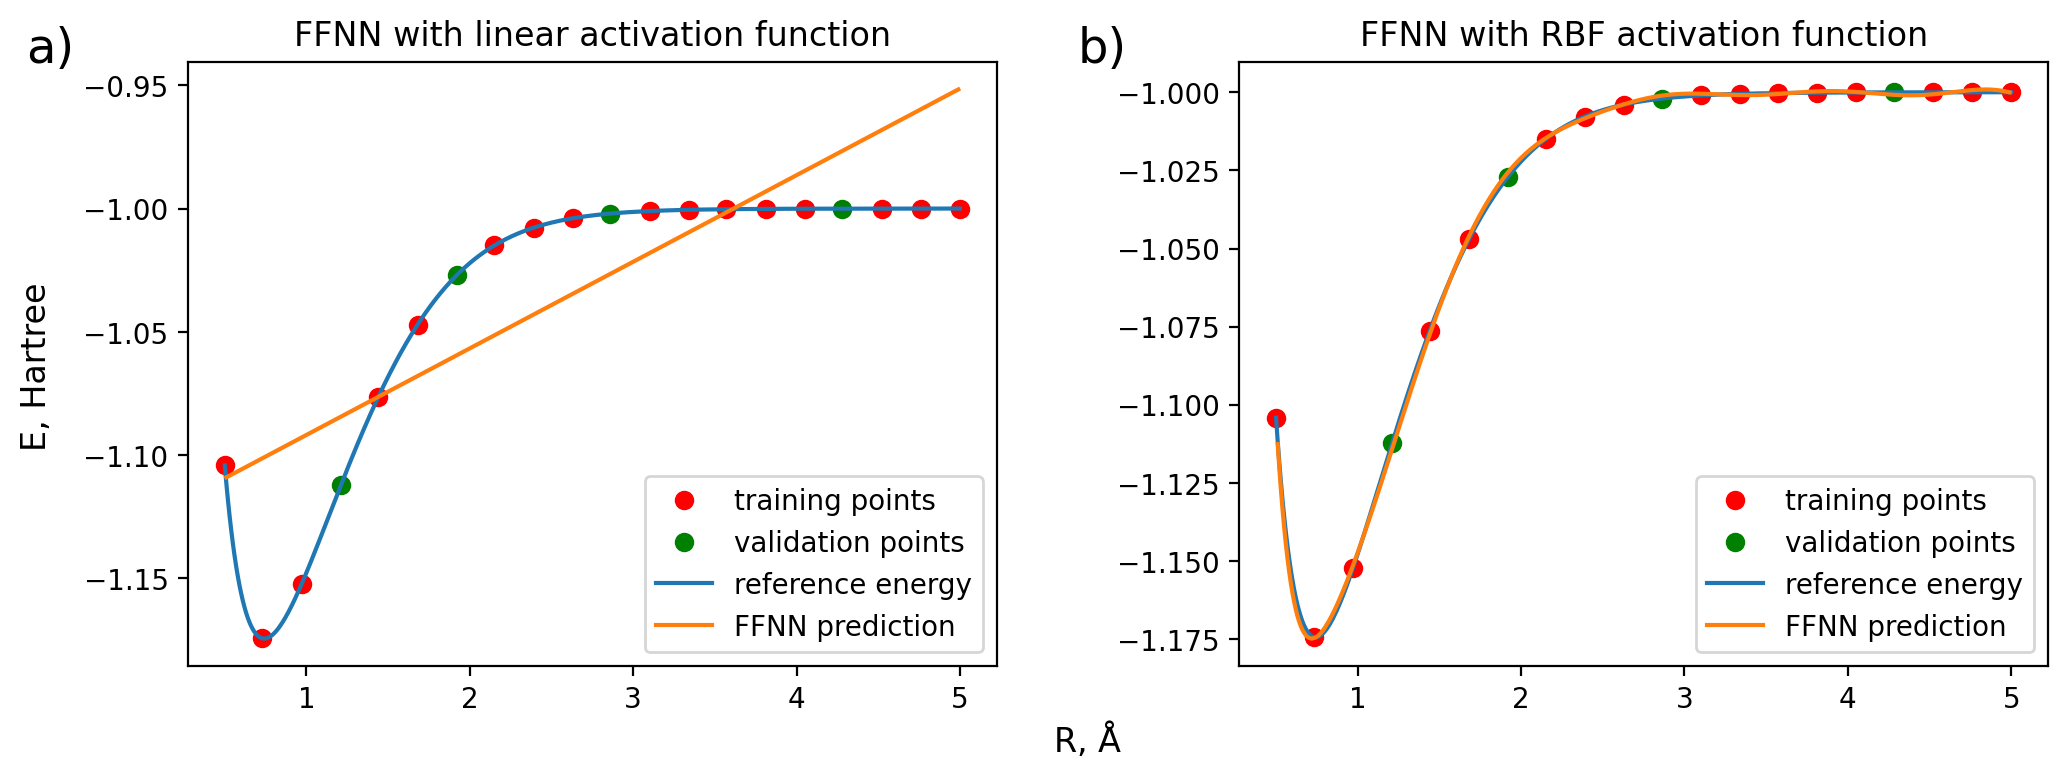

In [ ]:
plt.figure(figsize=(12, 4), dpi=200)
plt.gcf().supxlabel(r'R, $\mathrm{\AA}$ ')
plt.gcf().supylabel('E, Hartree', x=0.055)
plt.subplots_adjust(wspace=0.3)

plt.subplot(121)
plt.plot(x_train, y_train, 'ro', label='training points')
plt.plot(x_val, y_val, 'go', label='validation points')
plt.plot(X_all, Y_all, label='reference energy')
linear_model.eval()
plt.plot(x_test, linear_model(x_test).detach(), label='FFNN prediction')
plt.title('FFNN with linear activation function')
plt.text(x=-0.2, y=1, s='a)', fontsize='xx-large', transform=plt.gca().transAxes)
plt.legend()

plt.subplot(122)
plt.plot(x_train, y_train, 'ro', label='training points')
plt.plot(x_val, y_val, 'go', label='validation points')
plt.plot(X_all, Y_all, label='reference energy')
linear_model.eval()
plt.plot(x_test, rbf_model(x_test).detach(), label='FFNN prediction')
plt.title('FFNN with RBF activation function')
plt.text(x=-0.2, y=1, s='b)', fontsize='xx-large', transform=plt.gca().transAxes)
plt.legend()

plt.savefig('FFNN_fitting.jpg')